In [1]:
from HeaderP import *

In [2]:
import Astraea

In [6]:
def readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread):
    if simNo=='data':
        data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
        data['z_today']=data['z']
        data['x_today']=data['X']
        data['y_today']=data['Y']
        data['feh_scale']=data['M_H']
        data['ofe_scale']=data['O_FE']
        data['age']=data['Age']
    elif select:
        data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_apogee_selec.pkl')
        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    
    elif not select:
        if z=='0':
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'.pkl')
        else:
            data=pd.read_pickle('/Users/yl4331/Desktop/SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
            try:
                data['x_today']=data['x']
                data['y_today']=data['y']
                data['z_today']=data['z']
            except:
                print(np.shape(data['x_today']))

        data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
        data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
        scale_fe=0.250019907951355/0.35828184923028494
        scale_o=0.10861970484256744/0.09543676896214373
        data['feh_scale']=data['feh']*scale_fe-0.0906638577580452+0.08980628554112494
        data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-0.17121922547292423
        
        if Rcut:
            data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
            data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        data['dR']=data['R']-data['R_bir']
        data['dz']=abs(data['z_today'])-abs(data['z_birth'])
    return data
        

# load simulation

In [66]:
simNo='2_79e12'
z='0'
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5


data=readsimdata(simNo,z,Rcut,select,Rcut_thread,zcut_thread)

# use only [Fe/H] and Age

In [67]:
def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [94]:
from itertools import combinations_with_replacement

args = data['feh_scale'], data['age']
args_name = '[Fe/H]', 'Age'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(7528957, 5) (5,) 2


In [95]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [96]:
weights = train(y_train, X_train)

(-150.0, 150.0)

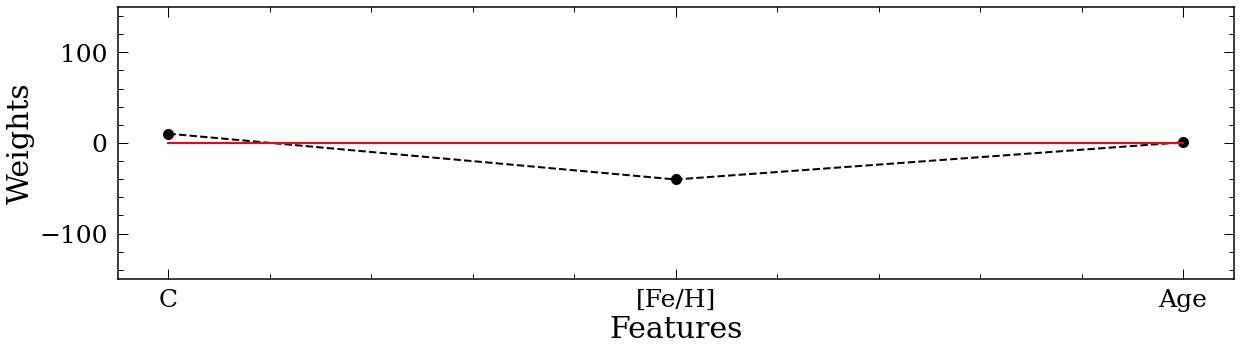

In [97]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-150,150])

In [98]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

In [99]:
"""
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from mlxtend.evaluate import bias_variance_decomp
model = LinearRegression()
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train,
                                                            y_train, X_test,
                                                            y_test,
                                                            loss='mse',
                                                            num_rounds=50,
                                                            random_seed=20)
"""

"\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.datasets import fetch_california_housing\nfrom mlxtend.evaluate import bias_variance_decomp\nmodel = LinearRegression()\navg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train,\n                                                            y_train, X_test,\n                                                            y_test,\n                                                            loss='mse',\n                                                            num_rounds=50,\n                                                            random_seed=20)\n"

Text(0.5, 1.0, 'scatter = 1.85832; bias = 0.00057')

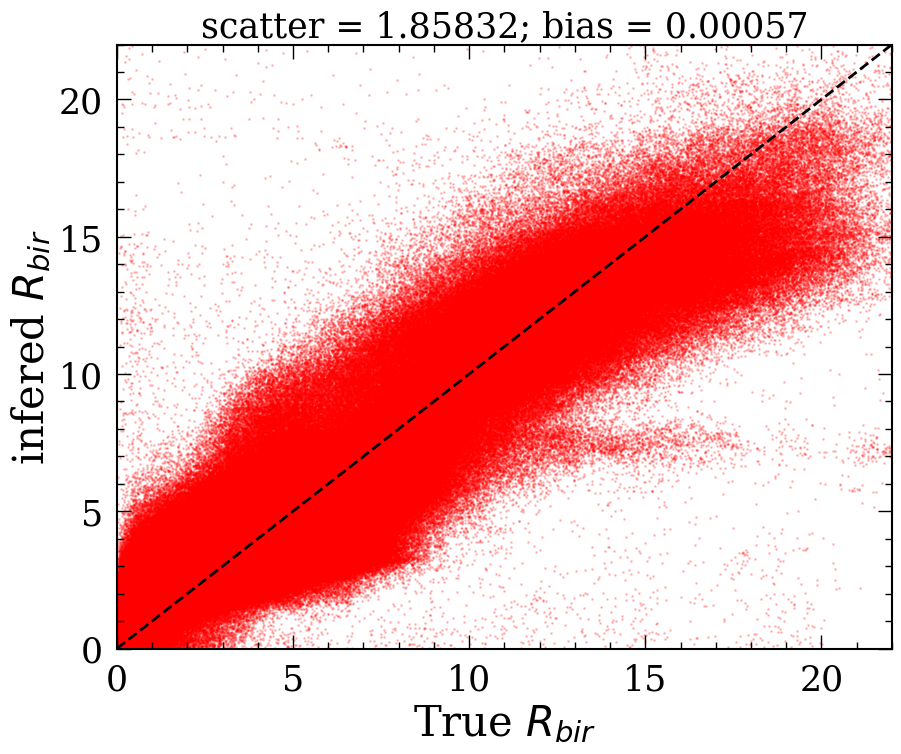

In [100]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_test, y_predict.T, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)

# use [Fe/H], [O/Fe], and Age

In [125]:
args = data['feh_scale'], data['ofe_scale'], data['age']
args_name = '[Fe/H]', '[O/Fe]', 'Age'
X = list(args)
X_names = list(args_name)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)

for a, b in combinations_with_replacement(args_name, 2):
    X_names.append(str(a + '*' + b))
    
    
X = np.array(X).T
print(np.shape(X), np.shape(X_names), len(args))

(7528957, 9) (9,) 3


In [126]:
# Define the number of training and validating stars.
Ntrain = int(0.8*np.shape(X)[0])
y = data['R_bir'].values

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

In [127]:
weights = train(y_train, X_train)

(-150.0, 150.0)

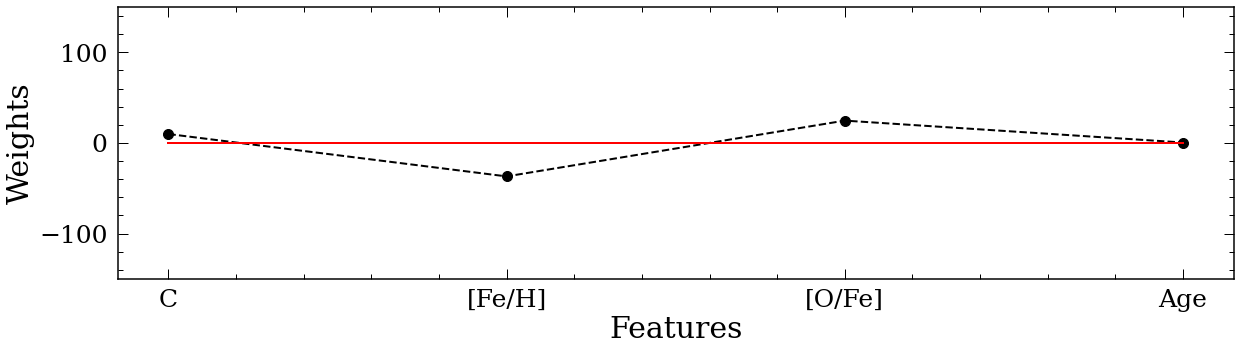

In [128]:
plt.figure(figsize=(20,5))
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)], weights[:(len(args_name)+1)], 'k--o', markersize=10)
plt.plot(np.append(['C'],X_names)[:(len(args_name)+1)],np.zeros(len(np.append(['C'],X_names)))[:(len(args_name)+1)],'r-')
plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-150,150])

In [129]:
A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
y_predict = np.dot(weights.T, A.T)

Text(0.5, 1.0, 'scatter = 1.81645; bias = -0.00087')

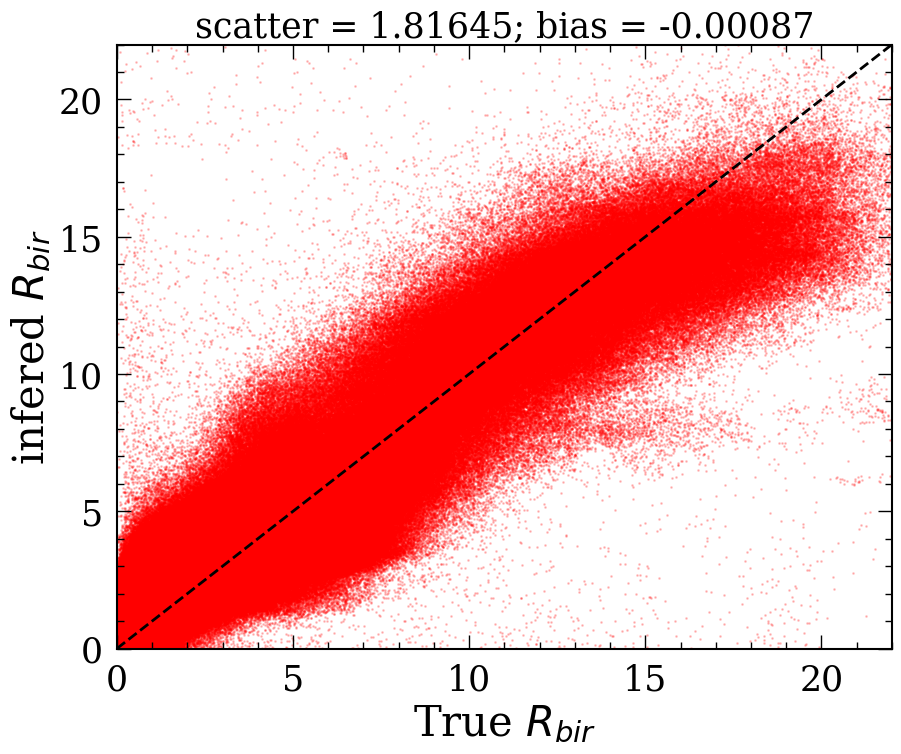

In [130]:
xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)

scatter = np.std(y_test-y_predict)
bias  = np.mean(y_test-y_predict)

plt.scatter(y_test, y_predict.T, s=1, c='r', alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)